In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

In [3]:
class Simulator:
    def __init__(self, p):
        self.p = p
        self.q = 1 - p
        self.N = p.shape[0]
        self.J = p.shape[1]

    def optimize(self, price, budget, q=None):
        q = self.q if q is None else q
        constraints = {"type": "ineq", "fun": lambda K: budget - price @ K}
        bounds = tuple([(0, None)] * self.J)

        return scipy.optimize.minimize(
            fun=lambda K: -np.mean(1 - np.prod(q ** K, axis=1)),
            x0=np.zeros(self.J),
            constraints=constraints,
            bounds=bounds,
            tol=10e-10,
        )

    def adjust_q_hat(self, q_hat, L, K):
        def adjust_q_j_hat(q_hat, L, K):
            var_q_hat = q_hat * (1 - q_hat) / L
            q_adj = np.ones((self.N, K + 1))
            q_adj[:, 1] = q_hat
            for k in range(2, K + 1):
                q_adj[:, k] = (
                    q_hat ** k - 0.5 * k * (k - 1) * q_adj[:, k - 2] * var_q_hat
                )
            return q_adj[:, -1]

        return np.column_stack(
            [adjust_q_j_hat(q_hat[:, j], L, K[j]) for j in range(self.J)]
        )

    def calc_theoretical_reach(self, K):
        return np.mean(1 - np.prod(self.q ** K, axis=1))

    def simulate(self, L, K, S=100):
        R_hat, R_adj = np.zeros(S), np.zeros(S)
        for s in range(S):
            q_hat = 1 - np.random.binomial(L, self.p, size=(self.N, self.J)) / L
            R_hat[s] = np.mean(1 - np.prod(q_hat ** K, axis=1))

            q_adj = self.adjust_q_hat(q_hat, L, K)
            R_adj[s] = np.mean(1 - np.prod(q_adj, axis=1))

        return (R_hat.mean(), R_adj.mean())

In [4]:
simulator = Simulator(p=np.array([[1 / 3, 2 / 3], [2 / 3, 1 / 3]]))
simulator.optimize(price=np.ones(2), budget=2)

     fun: -0.7777777777777777
     jac: array([-0.16711971, -0.16711971])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1., 1.])

In [5]:
simulator = Simulator(p=np.random.beta([4, 3], 200, size=(1000, 2)))
simulator.optimize(price=np.ones(2), budget=100)

     fun: -0.7976376421246738
     jac: array([-0.00276907, -0.00276908])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([87.73216921, 12.26783079])

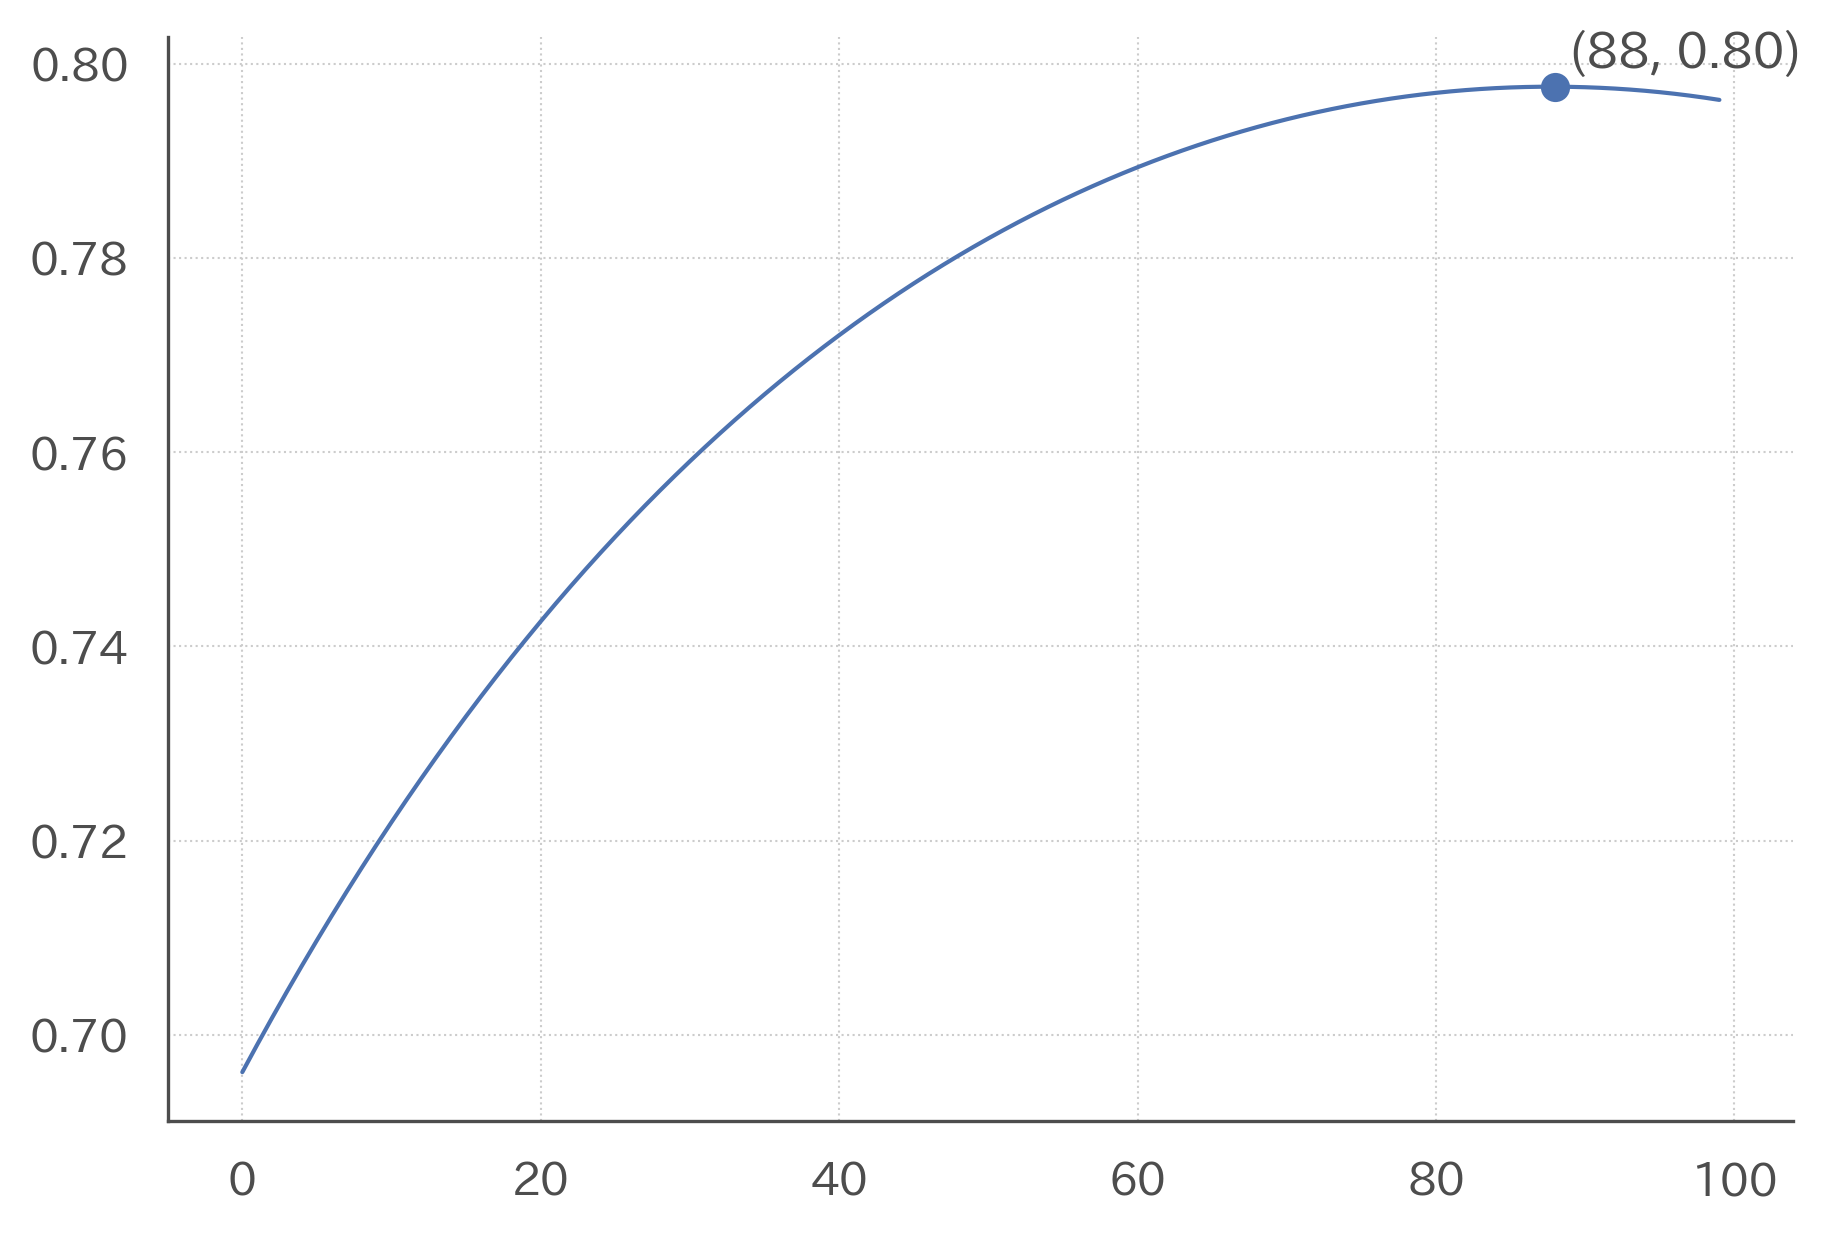

In [6]:
Rs = np.zeros(100)
Ks = np.array([[x, 100 - x] for x in range(101)])
for s in range(100):
    Rs[s] = simulator.calc_theoretical_reach(Ks[s])

fig, ax = plt.subplots()
ax.plot(range(100), Rs, linewidth=1, zorder=1)
ax.scatter(Rs.argmax(), Rs.max(), zorder=2)
ax.text(Rs.argmax() + 1, Rs.max() + 0.002, s=f"({Rs.argmax()}, {Rs.max():.2f})")
ax.set(xlabel=None, ylabel=None)
fig.savefig("figure/opt.png")

In [7]:
K = np.array([10] * 10)
simulator = Simulator(p=np.random.beta(1, 49, size=(1000, 10)))
print(f"理論値：{simulator.calc_theoretical_reach(K):.3f}")
print(f"推定値：{simulator.simulate(L=50, K=K)[0]:.3f}")

理論値：0.845
推定値：0.820


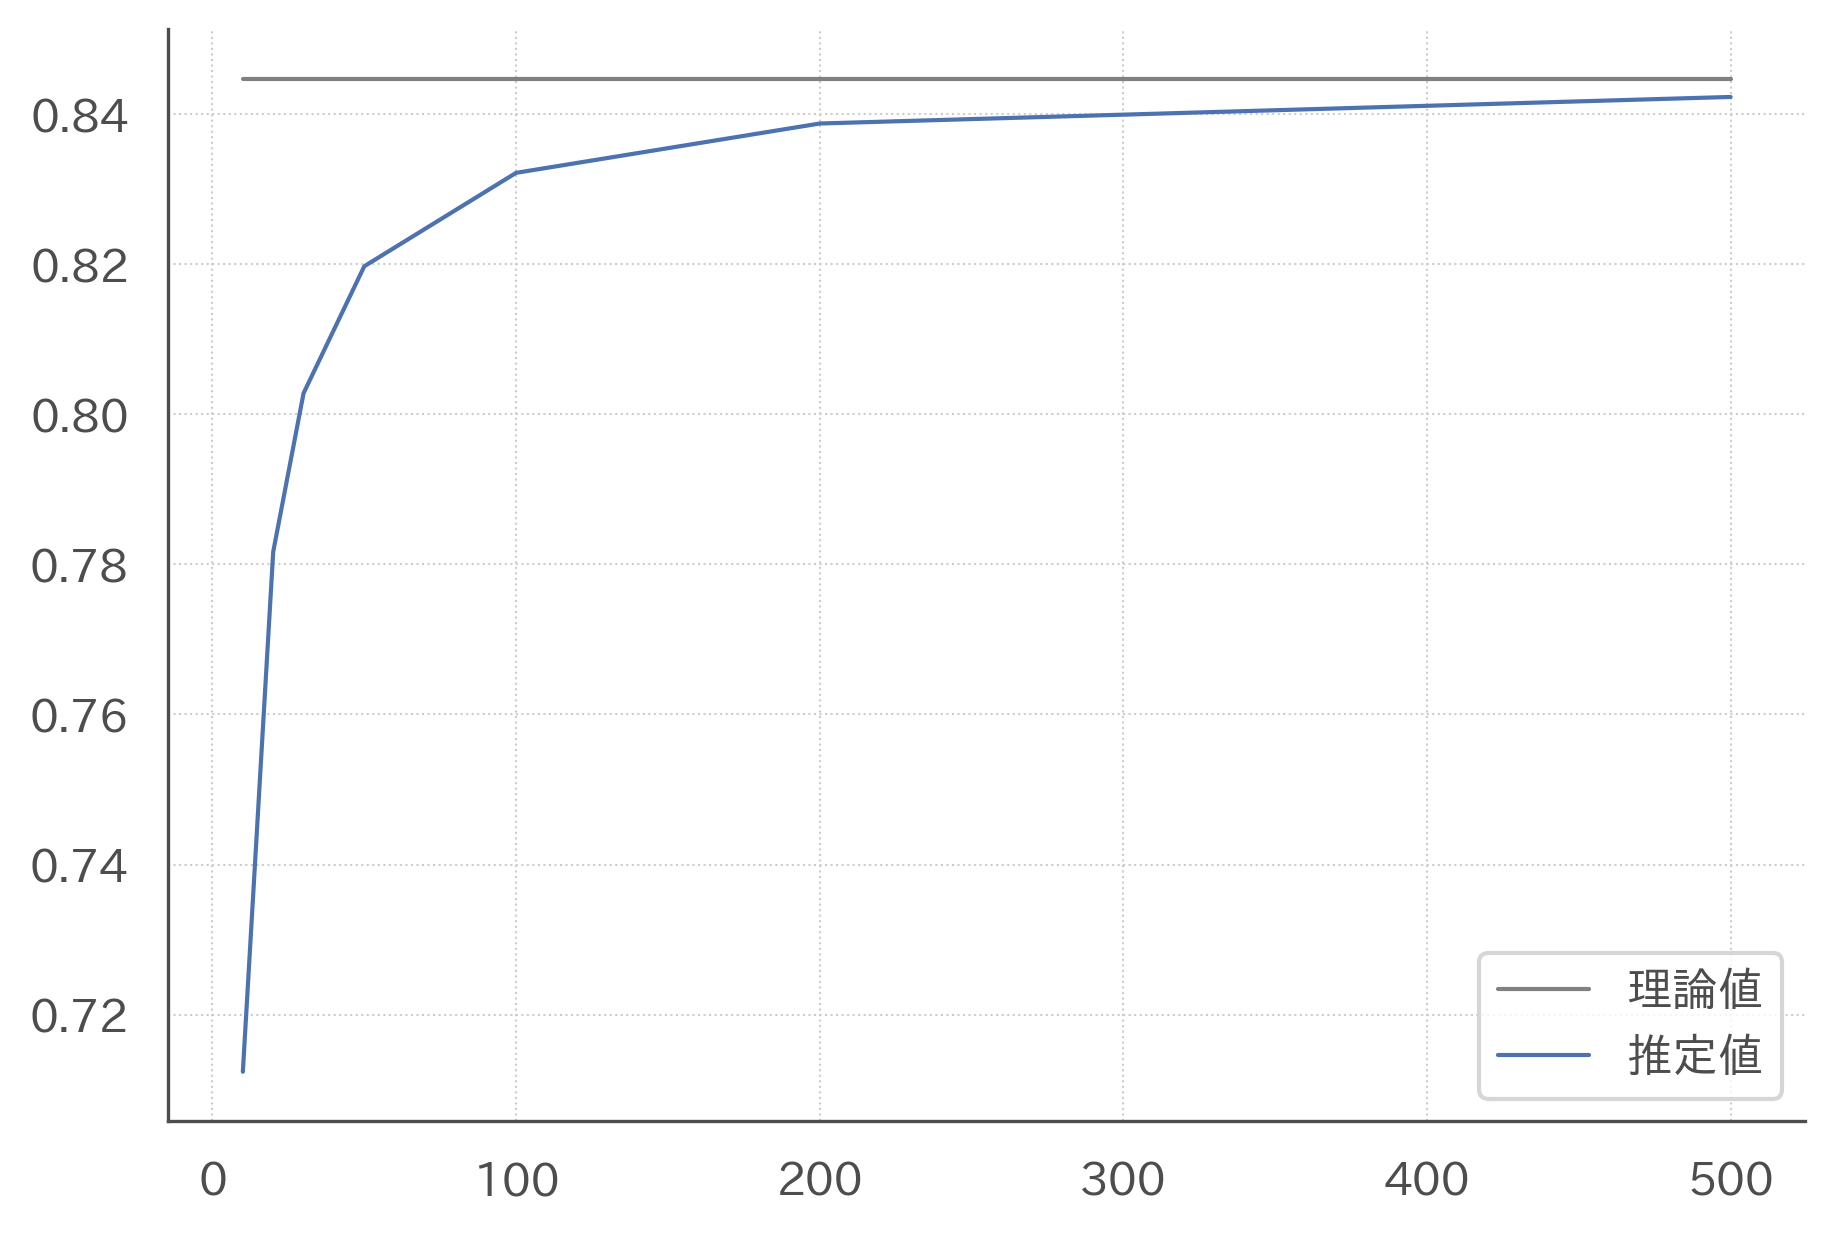

In [8]:
R = simulator.calc_theoretical_reach(K)
Ls = [10, 20, 30, 50, 100, 200, 500]
R_hat, R_adj = np.zeros((2, len(Ls)))

for l, L in enumerate(Ls):
    R_hat[l], R_adj[l] = simulator.simulate(L, K)

fig, ax = plt.subplots()
ax.plot(Ls, [R] * len(Ls), label="理論値", linewidth=1, color=".5")
ax.plot(Ls, R_hat, label="推定値", linewidth=1)
ax.legend()
ax.set(xlabel=None, ylabel=None)
fig.savefig("figure/r_hat.png")

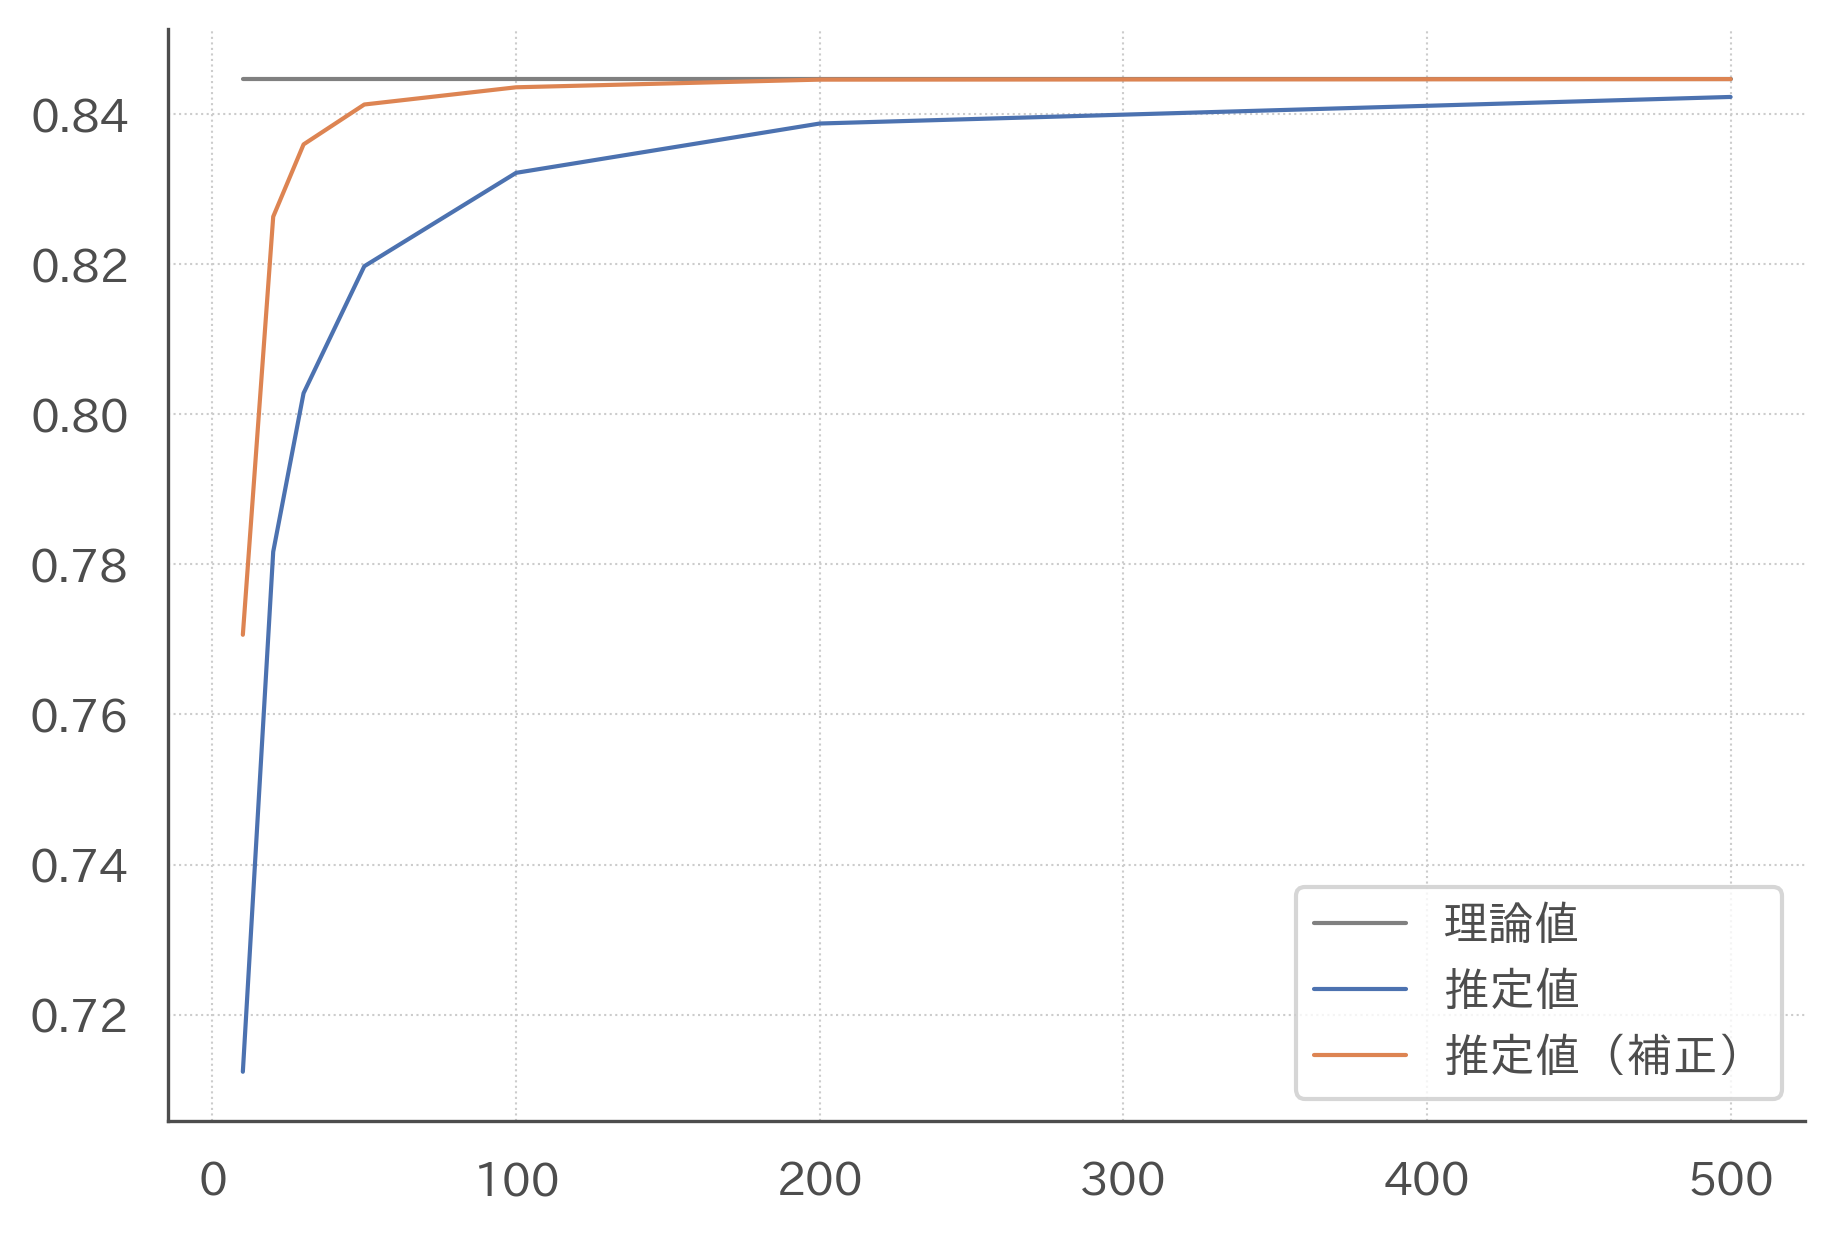

In [9]:
fig, ax = plt.subplots()
ax.plot(Ls, [R] * len(Ls), label="理論値", linewidth=1, color=".5")
ax.plot(Ls, R_hat, label="推定値", linewidth=1)
ax.plot(Ls, R_adj, label="推定値（補正）", linewidth=1)
ax.legend()
ax.set(xlabel=None, ylabel=None)
fig.savefig("figure/r_adj.png")

In [10]:
def adjust2(q_hat, M, K):
    I = q_hat.shape[0]
    J = q_hat.shape[1]

    q_adj = np.zeros_like(q_hat)
    for j in range(J):
        q_j_adj = np.ones((I, K[j] + 1))
        var_q_hat = q_hat[:, j] * (1 - q_hat[:, j]) / M
        q_j_adj[:, 1] = q_hat[:, j]
        mu_coef = np.array([0, 1])
        for k in range(2, K[j] + 1):
            mu_poly = np.polynomial.polynomial.Polynomial(mu_coef)
            mu_coef = np.array(mu_poly.deriv().coef.tolist() + [0, 0]) + np.array([0] + mu_poly.coef.tolist())
            sigma_power = np.array([k/2 if k%2 == 0 else 0 for k in reversed(range(k+1))]).reshape(1, -1)
            q_j_adj[:, k] = q_hat[:, j] ** k - np.sum((q_j_adj[:, :k] * mu_coef[:-1]) * (var_q_hat.reshape(-1, 1) ** sigma_power[:, :-1]), axis=1)

        q_adj[:, j] = q_j_adj[:, -1]

    return q_adj